In [1]:
import cv2 #opencv读取的格式是BGR
import matplotlib.pyplot as plt 
import numpy as np 
%matplotlib inline
# np.set_printoptions(threshold=np.inf)

In [2]:
img_1 = cv2.imread('face.png')[:,:,0]
#img_gray = cv2.imread('lena512.bmp',cv2.IMREAD_GRAYSCALE).shape
img_2 = cv2.imread('cameraman.png')[:,:,0]
img_3 = cv2.imread('crowd.png')[:,:,0]
img_4 = cv2.imread('Histogram_Equalization.png')
img_5 = cv2.imread('Spatial_Filtering.png',cv2.IMREAD_GRAYSCALE).astype(float)
img_6 = cv2.imread('Frequency_Filtering.png')[:,:,0]

In [3]:
def show_img(img):
    plt.imshow(img,'gray')

In [4]:
def interpolation_bilinear(a,size:tuple):
#     a represents the original image
#     b represents the destination image
    y_size,x_size = size
    b = np.zeros((x_size,y_size))

    x_ratio = (a.shape[1] - 1) / (x_size - 1)
    y_ratio = (a.shape[0] - 1) / (y_size - 1)
    
    #the length and width of original image
    a_x_size = a.shape[1]
    a_y_size = a.shape[0]
    for y in range(y_size):
        for x in range(x_size):
            #(x,y) is the point of destination image 
            x_orign = x * x_ratio
            y_orign = y * y_ratio
            
            x_0 = np.floor(x_orign).astype(int)
            y_0 = np.floor(y_orign).astype(int)
            x_1 = min(x_0 + 1, a_x_size - 1)
            y_1 = min(y_0 + 1, a_y_size - 1)
            
            #x_up and y_up are decimals of (x_origin, y_origin)
            x_up = x_orign - x_0
            y_up = y_orign - y_0

            b[x, y] = (1-x_up)*(1-y_up)*a[x_0,y_0] + x_up*(1-y_up)*a[x_1,y_0] + (1-x_up)*y_up*a[x_0,y_1] + x_up*y_up*a[x_1,y_1]
    return b
#cv2.resize(img_half_pixel,(800,1000),interpolation=cv2.INTER_CUBIC)

In [5]:
def draw_downsampling(img):
    fig_1_a = plt.figure(figsize=(16, 12))
    for i in range(1,4):
        times = 2 ** i
        ax = fig_1_a.add_subplot(130 + i)
        ax.set_title("Downsample an image to 1/"+str(times))
        img = interpolation_bilinear(img, (256,256))
        show_img(interpolation_bilinear(img,(img.shape[1] // times,img.shape[0] // times)))
        # plt.subplot(221)
        # show_img(interpolation_bilinear(img_gray,(img_gray.shape[1] // 2,img_gray.shape[0] // 2)))

In [6]:
def draw_recovery(img):
    fig_1_a = plt.figure(figsize=(16, 12))
    for i in range(1,4):
        times = 2 ** i
        ax = fig_1_a.add_subplot(130 + i)
        ax.set_title("Recovery form 1/"+str(times))
        img = interpolation_bilinear(img, (256,256))
        img_down = interpolation_bilinear(img,(img.shape[1] // times,img.shape[0] // times))
        img_recovery = interpolation_bilinear(img_down,(256,256))
        show_img(img_recovery)

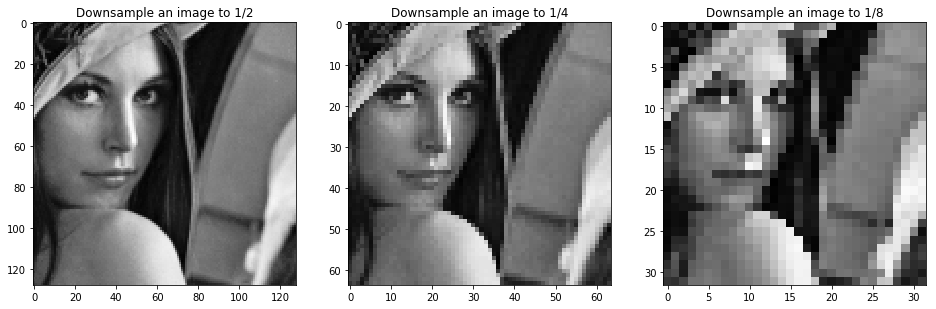

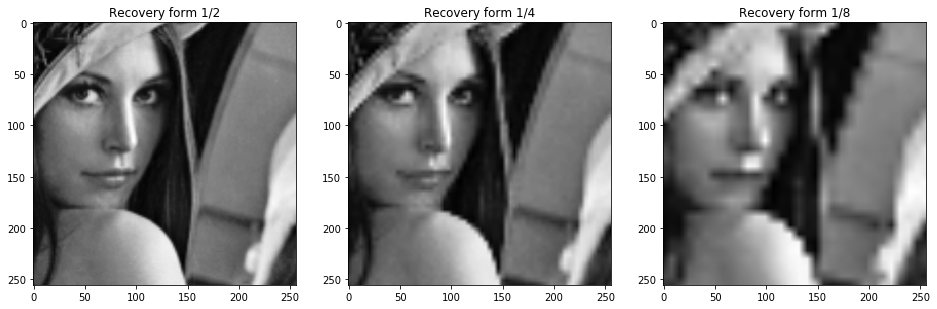

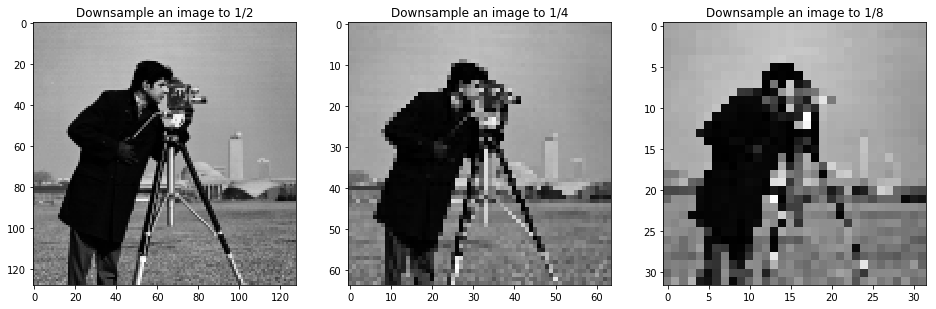

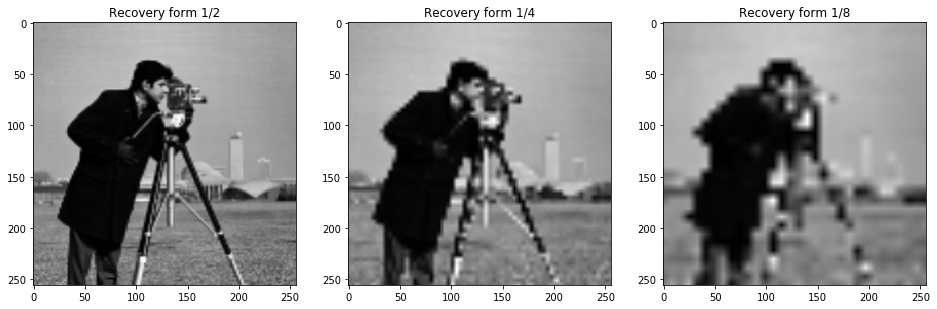

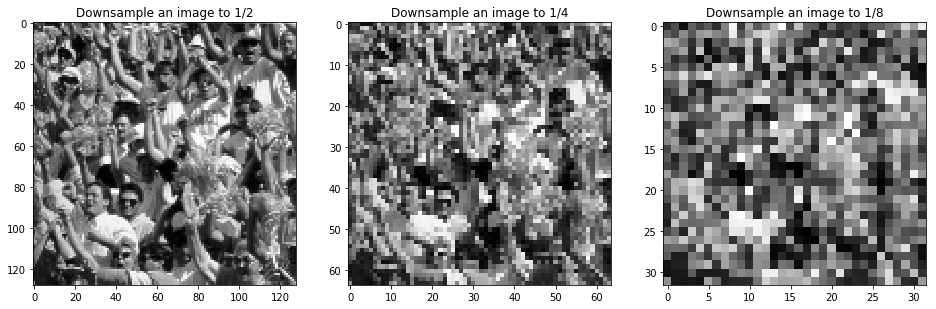

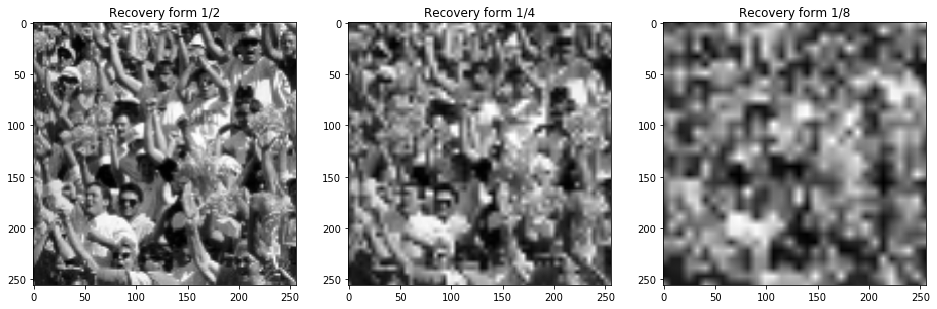

In [7]:
draw_downsampling(img_1)
draw_recovery(img_1)
draw_downsampling(img_2)
draw_recovery(img_2)
draw_downsampling(img_3)
draw_recovery(img_3)

In [8]:
def down_quantization(img, down_times):
    #用位运算做非常快
    mask = 0b11111111 << (down_times - 1)
    return img & mask

In [9]:
def draw_down_quantization(img):
    fig_1_b = plt.figure(figsize=(40,20))
    for i in range(1,9):
        ax = plt.subplot(240 + i)
#         ax.set_title("1/" + str(i) +" quantization level"+",k=" + str(9-i))
        ax.set_title("k=" + str(9-i),fontsize=30)
#         img = interpolation_bilinear(img,(256,256))
        show_img(down_quantization(img, i))

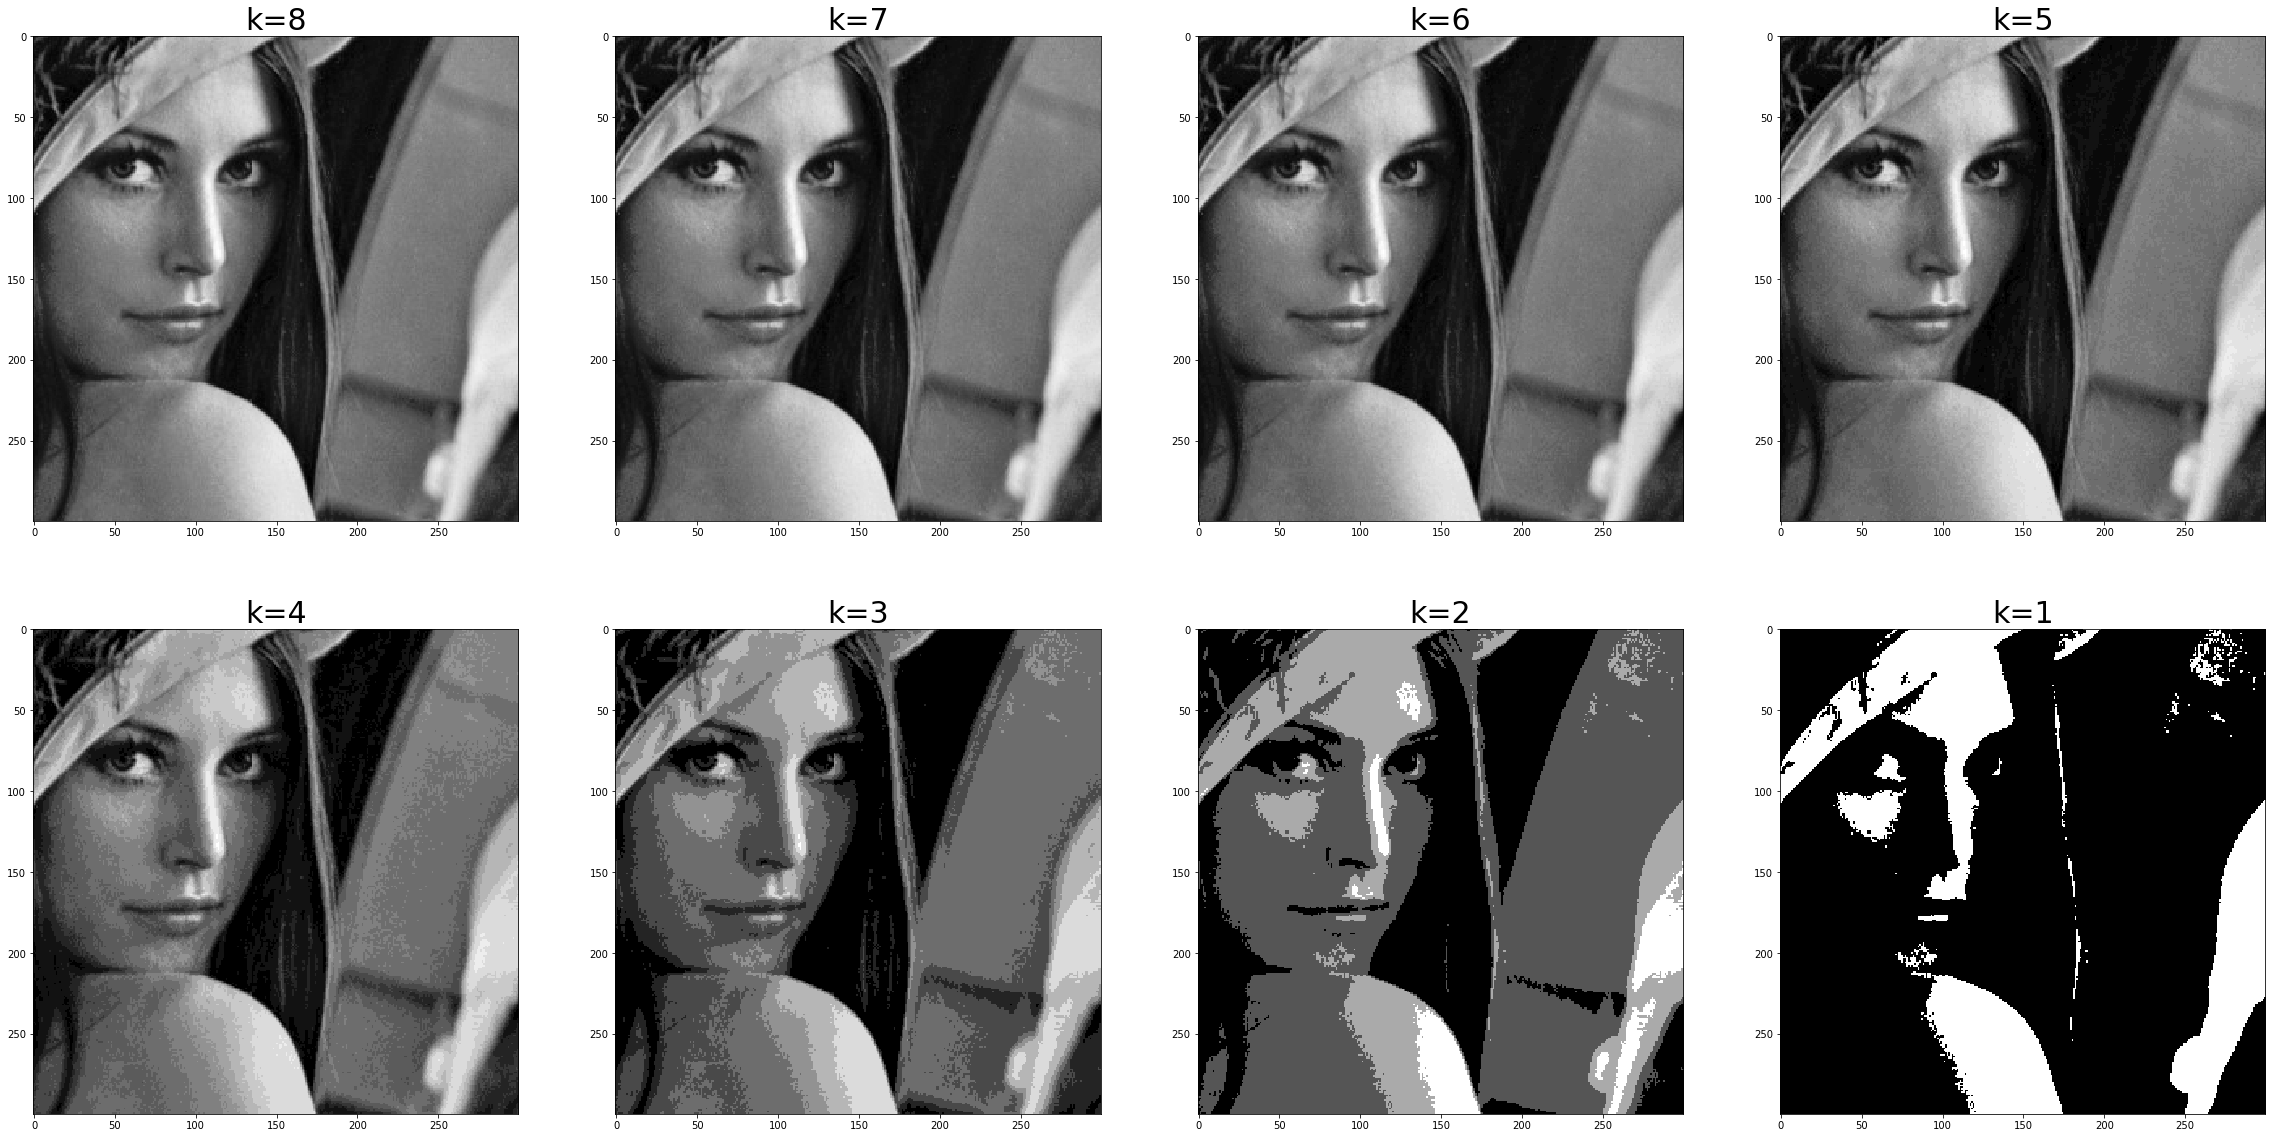

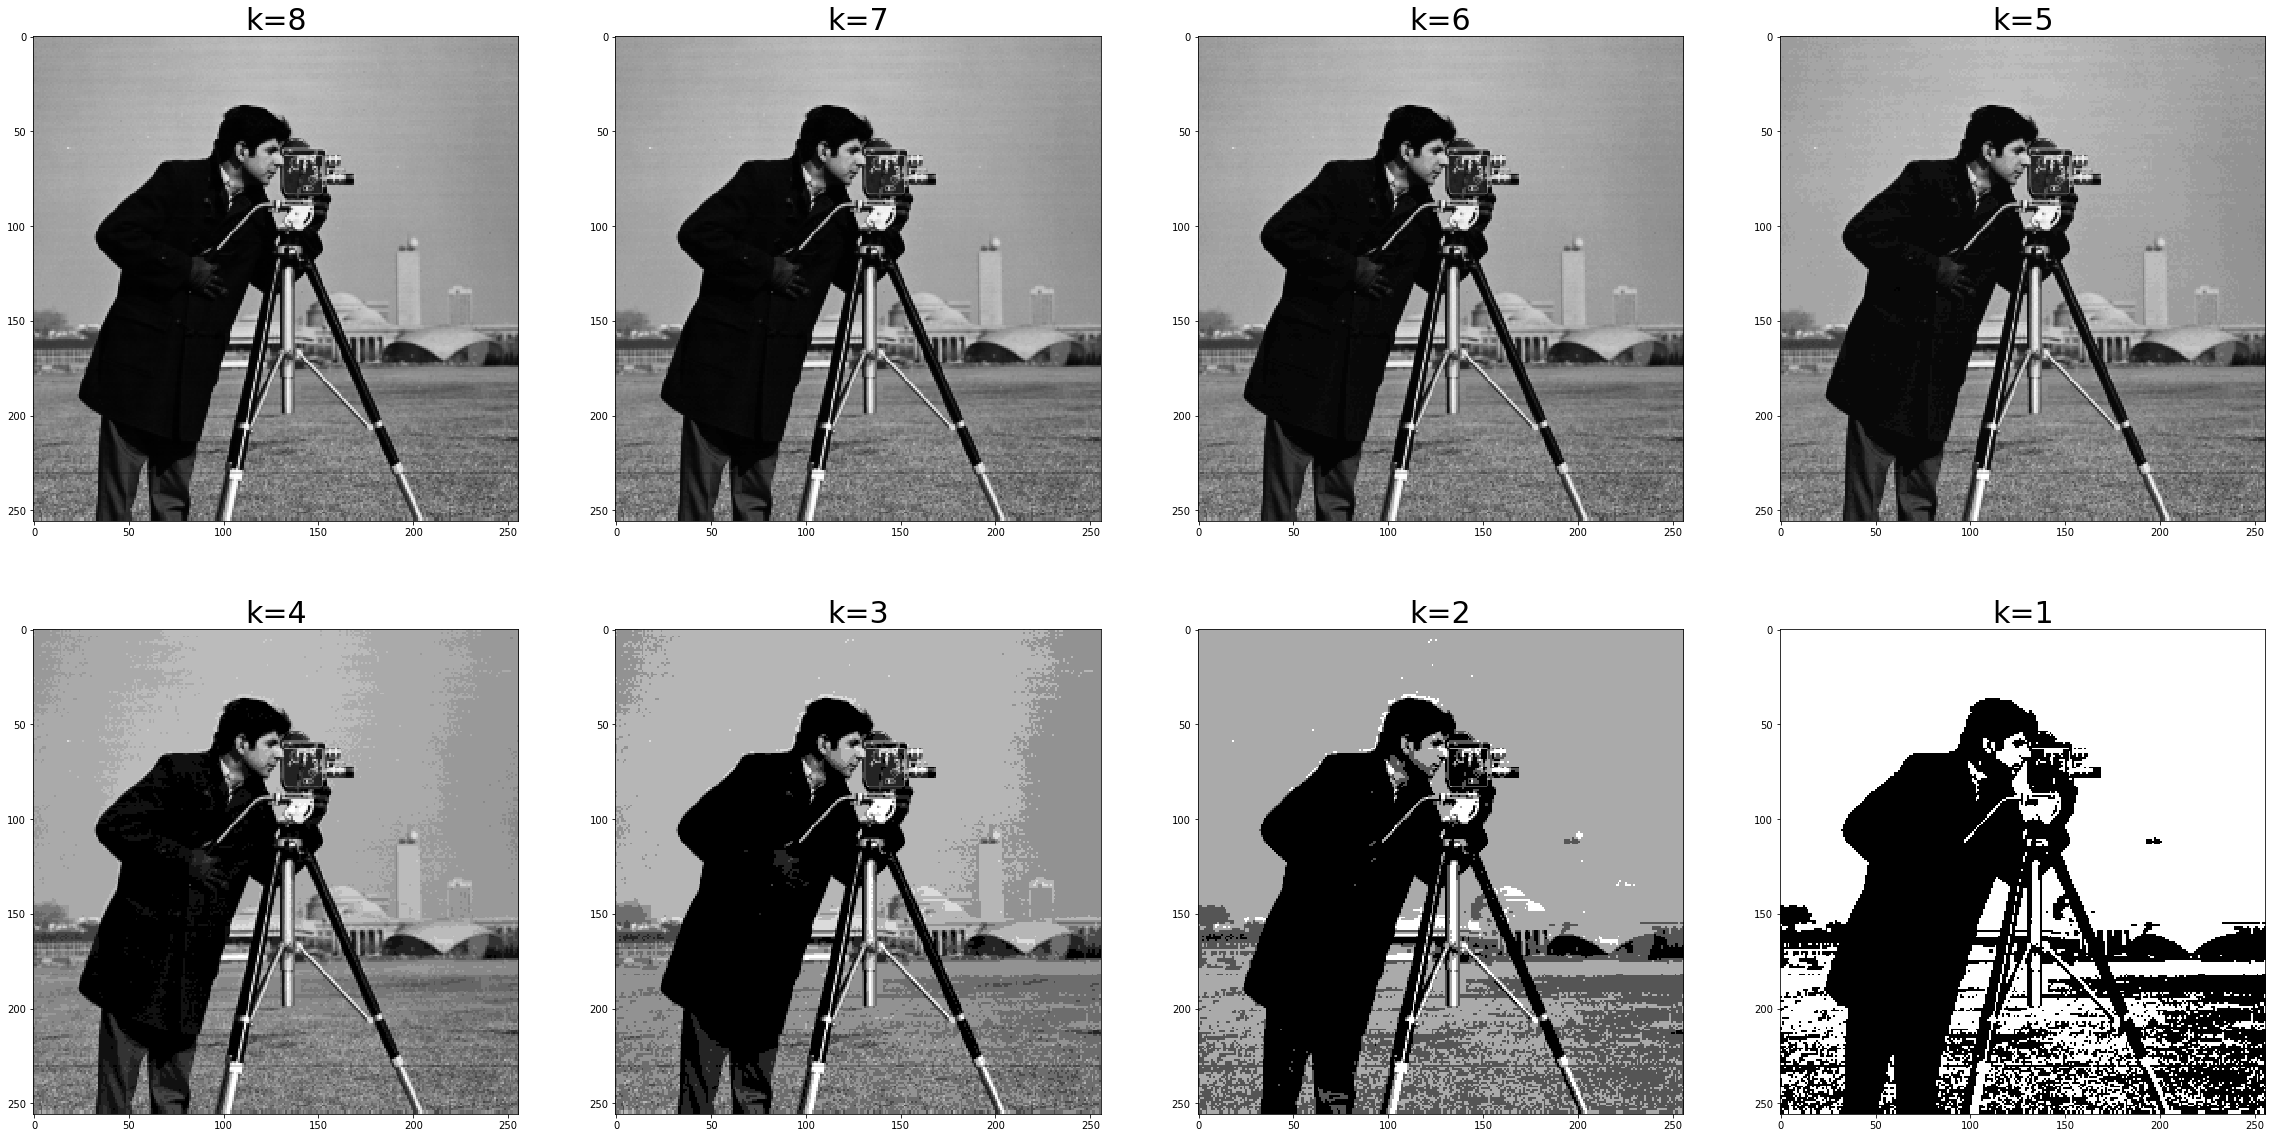

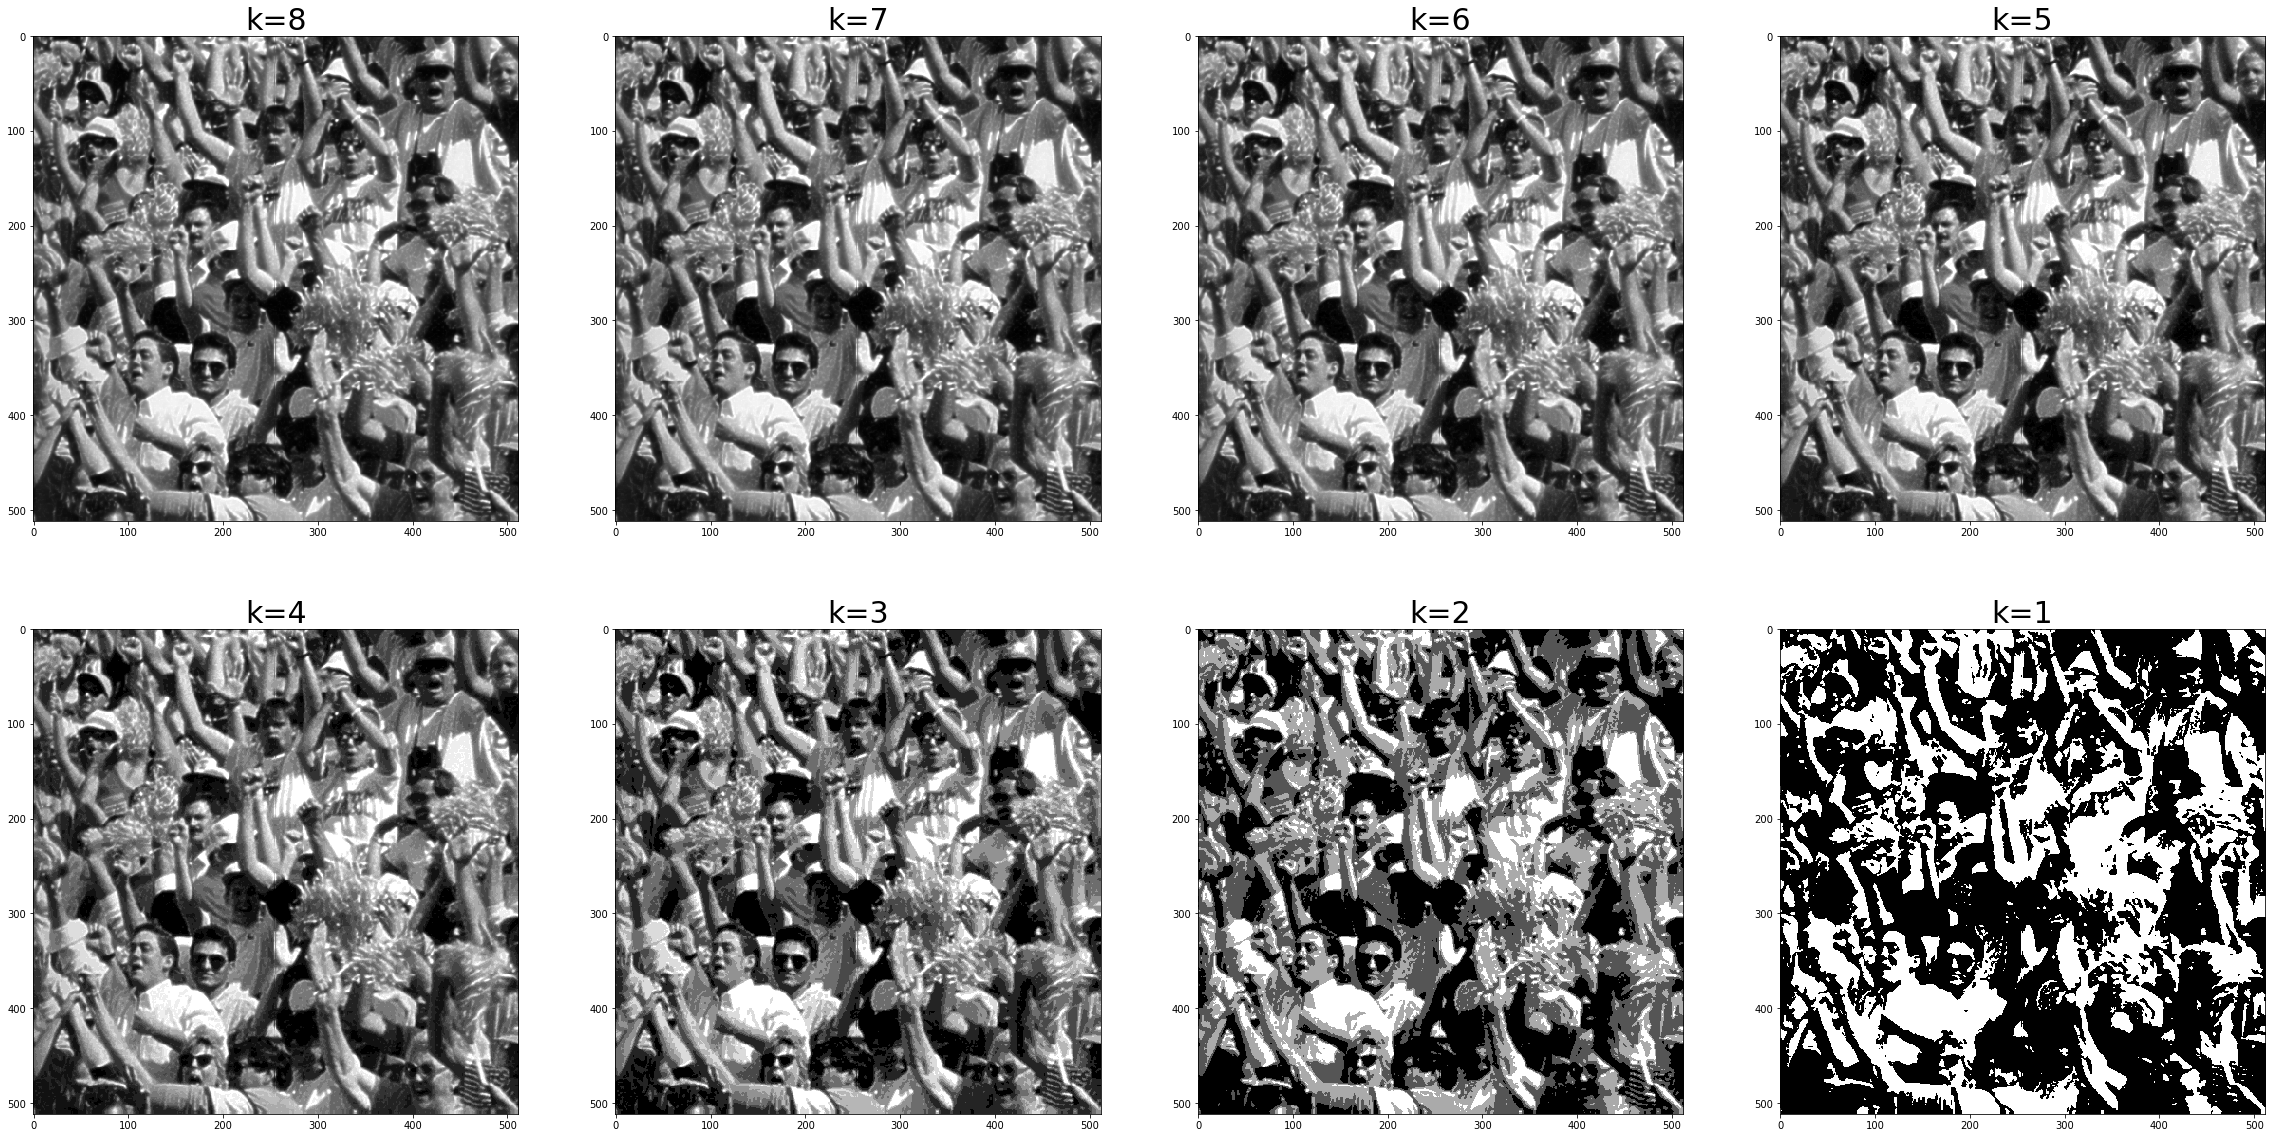

In [10]:
draw_down_quantization(img_1)
draw_down_quantization(img_2)
draw_down_quantization(img_3)

In [11]:
def histogram_equalization(img):
    #对于元素级的操作需要传递一个新的对象
    img = img.copy()
    L = 256
    MN = img.shape[0] * img.shape[1]
    T = {}
    for intensity in range(256):
        T[intensity] = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            T[img[i,j]] += 1
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            nk = 0
            for k in range(img[i,j]):
                nk += T[k]
            img[i,j] = (L - 1) / MN * nk
    return img

In [12]:
def RGB_histogram_equalization(img):
    dest_img = img.copy()
    for i in range(img.shape[2]):
        dest_img[:,:,i] = histogram_equalization(dest_img[:,:,i])
    return dest_img

Text(0.5,1,'Histogram Diagram After Histogram Equaliazation')

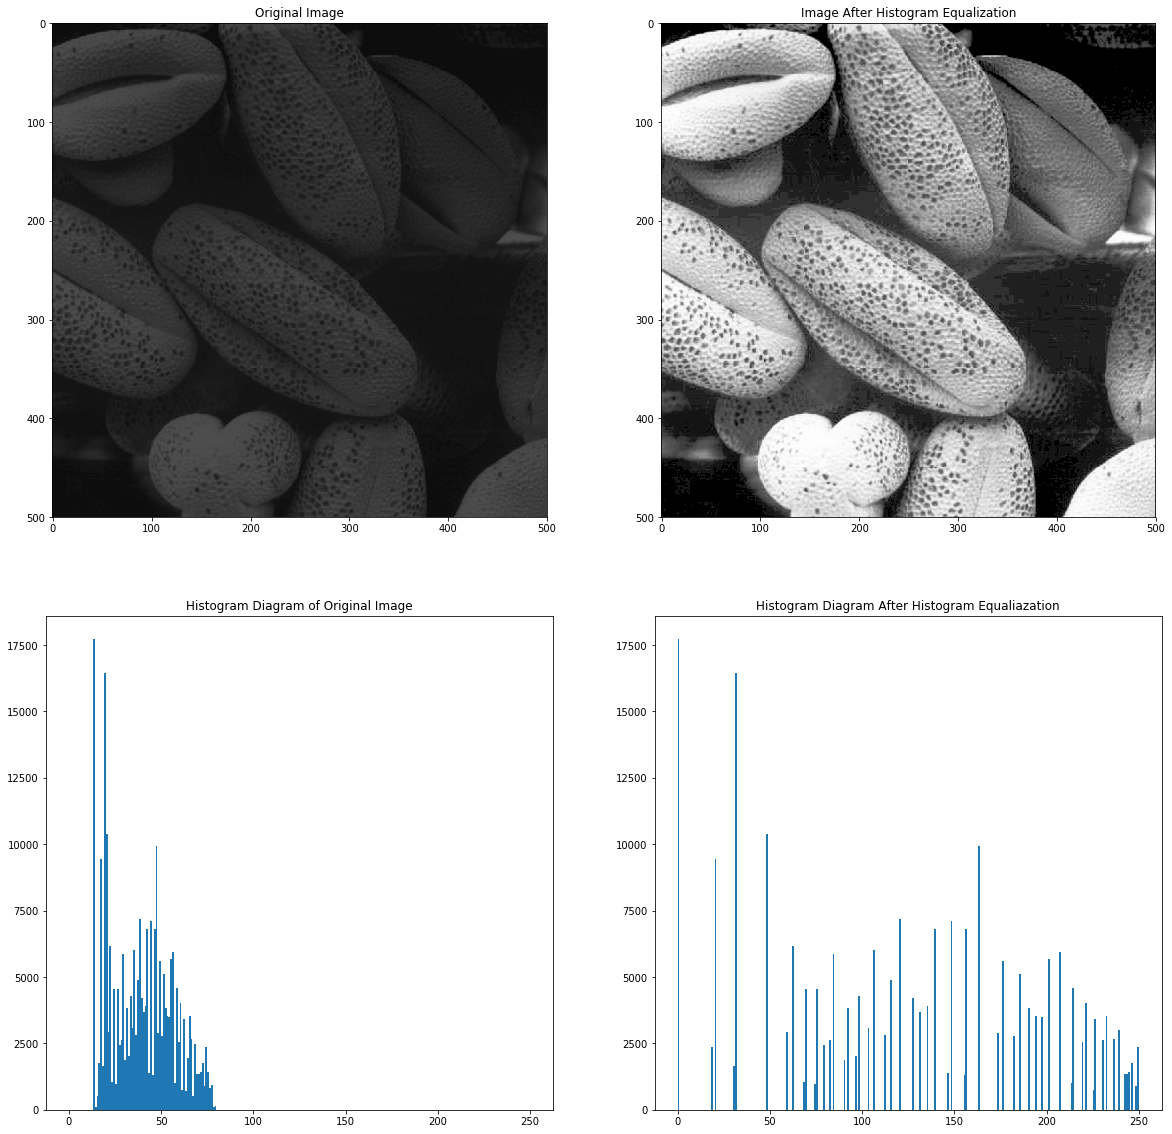

In [13]:
plt.figure(figsize=(20,20))

plt.subplot(221)
show_img(img_4)
plt.title('Original Image')

plt.subplot(222)
img_4_he = RGB_histogram_equalization(img_4)
show_img(img_4_he)
plt.title('Image After Histogram Equalization')

plt.subplot(223)
plt.hist(img_4[:,:,0].reshape(-1,),bins = 250,range=[0,250])
plt.title('Histogram Diagram of Original Image')

plt.subplot(224)
plt.hist(img_4_he[:,:,0].reshape(-1,),bins = 250,range=[0,250])
plt.title('Histogram Diagram After Histogram Equaliazation')

In [14]:
def sharpening_spatial_filter(img,kernel):
    des_img = img.copy()
    des_img.astype(float)
    for y in range(1,img.shape[0] - 1):
        for x in range(1,img.shape[1] - 1):
            des_img[y,x] = np.sum(np.multiply(img[y-1:y+2,x-1:x+2],kernel))
    return des_img
# lap_5 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
# lap_9 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
# dst = cv2.filter2D(img_7,cv2.CV_8U,lap_9)

In [15]:
def sharpening(img,lap):
    img = img + lap
    img = np.clip(img,0,255)
    return img

Text(0.5,1,'Image After Sharpening')

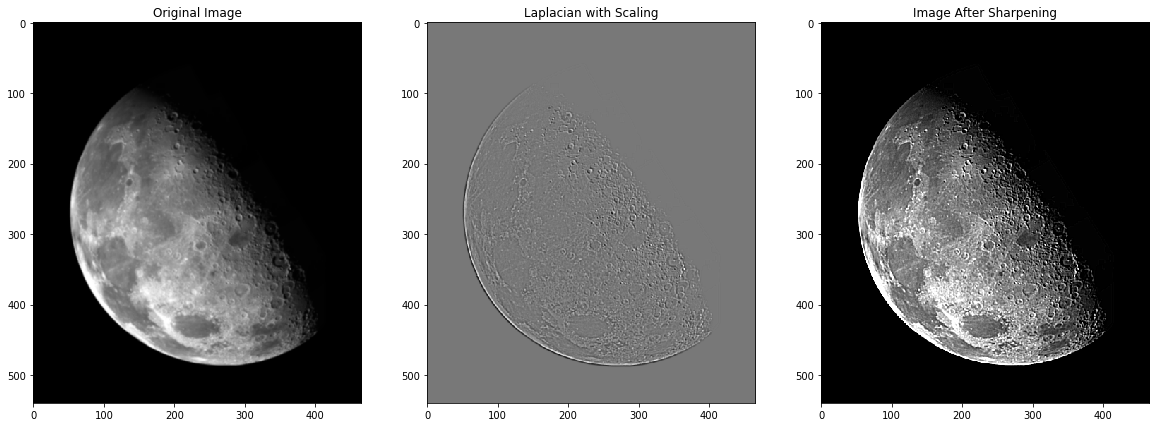

In [16]:
plt.figure(figsize=(20,20))

plt.subplot(131)
show_img(img_5)
plt.title('Original Image')

plt.subplot(132)
kernel = [[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]]
lap = sharpening_spatial_filter(img_5,kernel)
show_img(lap)
plt.title('Laplacian with Scaling')

plt.subplot(133)
show_img(sharpening(img_5,lap))
plt.title('Image After Sharpening')

In [17]:
from matplotlib.colors import LogNorm
from scipy import fftpack
from scipy import ndimage

def plot_spectrum(im_fft):
    # A logarithmic colormap
    
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
#     plt.imshow(np.abs(im_fft))
    plt.colorbar()

def filter_fft(remain_pencentage, img_fft):
    filter_fft = img_fft.copy()
    y_size, x_size = img_fft.shape
    filter_fft[int(y_size*remain_pencentage):int(y_size*(1-remain_pencentage))] = 0
    filter_fft[:, int(x_size*remain_pencentage):int(x_size*(1-remain_pencentage))] = 0
#     filter_fft[0:int(y_size*remain_pencentage)] = 0
#     filter_fft[int(y_size*(1-remain_pencentage)):y_size] = 0
#     filter_fft[int(y_size*remain_pencentage):int(y_size*(1-remain_pencentage)), int(x_size*remain_pencentage):int(x_size*(1-remain_pencentage))] = 0
    return filter_fft    

Text(0.5,1,'After Mdeian Filter')

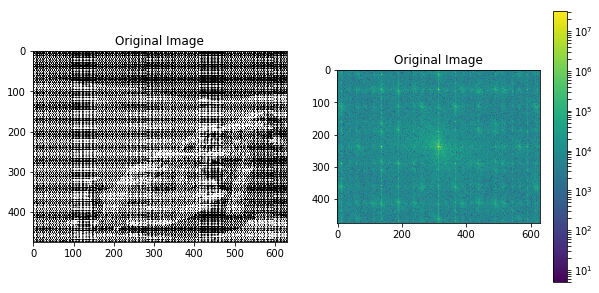

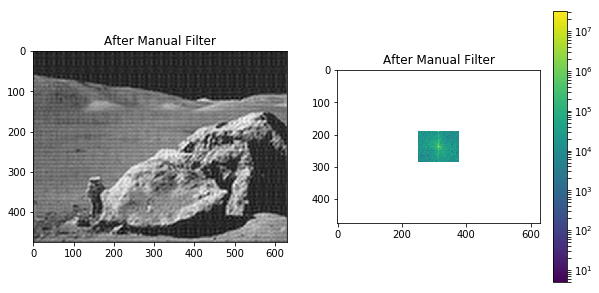

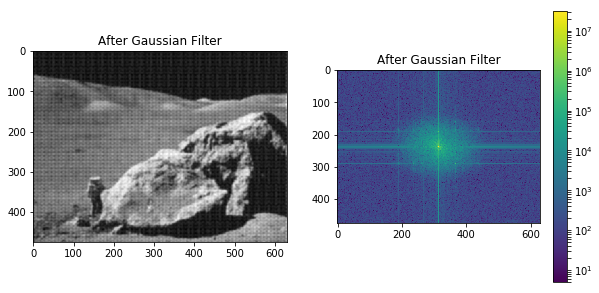

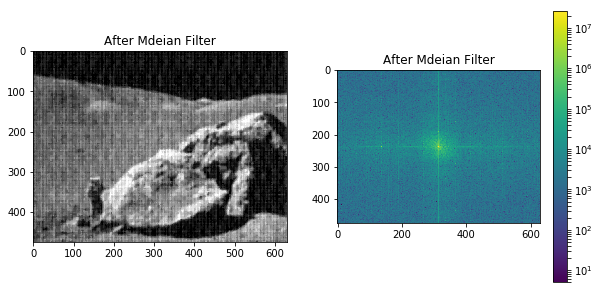

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img_6, plt.cm.gray)
plt.title('Original Image')

plt.subplot(122)
img_6_fft = fftpack.fft2(img_6)
img_6_fft_shift = np.fft.fftshift(img_6_fft)
plot_spectrum(img_6_fft_shift)
plt.title('Original Image')

plt.figure(figsize=(10,5))
plt.subplot(122)
filter_fft_img_6 = filter_fft(0.1, img_6_fft)
filter_fft_img_6_shift = np.fft.fftshift(filter_fft_img_6)
plot_spectrum(filter_fft_img_6_shift)
plt.title('After Manual Filter')

plt.subplot(121)
img_6_denoise = fftpack.ifft2(filter_fft_img_6).real
plt.imshow(img_6_denoise, plt.cm.gray)
plt.title('After Manual Filter')

plt.figure(figsize=(10,5))
plt.subplot(121)
img_6_gussian_filter = ndimage.gaussian_filter(img_6, 2)
plt.imshow(img_6_gussian_filter, plt.cm.gray)
plt.title('After Gaussian Filter')

plt.subplot(122)
plot_spectrum(np.fft.fftshift(fftpack.fft2(img_6_gussian_filter)))
plt.title('After Gaussian Filter')

plt.figure(figsize=(10,5))
plt.subplot(121)
img_6_median_filter = ndimage.median_filter(img_6,size=8)
plt.imshow(img_6_median_filter, plt.cm.gray)
plt.title('After Mdeian Filter')


plt.subplot(122)
plot_spectrum(np.fft.fftshift(fftpack.fft2(img_6_median_filter)))
plt.title('After Mdeian Filter')